# EONET: The Earth Observatory Natural Event Tracker


### EONET collects and updates metadata on natural events occurring on Earth, including information on geometries, types of events, and dates.

### Using API from NASA website 

The API documentation for EONET can be found in this link -> https://eonet.gsfc.nasa.gov/docs/v2.1 

Access the EONET API data through this endpoint: -> https://eonet.gsfc.nasa.gov/api/v2.1/events

In [516]:
# import related libraries

# making HTTP requests
import requests

# analysing data
import pandas as pd
import numpy as np 

# plot graph
import matplotlib.pyplot as plt
import seaborn as sns

# fitting simple linear regression
from sklearn.linear_model import LinearRegression
# splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
# fitting polynomial
from sklearn.preprocessing import PolynomialFeatures
# finding error both MSE and R^2
from sklearn.metrics import mean_squared_error, r2_score

# convert a string containing a list into an actual python list object
import ast # as i mentioned, if i do not fix this code, my csv file will not work with my data, even if my API works

In [517]:
# get API key from NASA website
api_key = 'KnO9y2DXhdnzH0ey1tglBohTkHzl8L0acd8AYQfa'

## Step 1: Crawl a real-world dataset

In [518]:
# create fetch_earth_event function to collect data from this url 'https://eonet.gsfc.nasa.gov/api/v2.1/events' and use an API key to authorize
def fetch_earth_event(api_key):
    # API endpoint of EONET dataset
    url = f"https://eonet.gsfc.nasa.gov/api/v2.1/events?api_key={api_key}"

    response = requests.get(url)
    
    return response.json()

check_fetch = fetch_earth_event(api_key)
print(check_fetch)

{'title': 'EONET Events', 'description': 'Natural events from EONET.', 'link': 'https://eonet.gsfc.nasa.gov/api/v2.1/events', 'events': [{'id': 'EONET_6469', 'title': 'Tropical Cyclone Alvaro', 'description': '', 'link': 'https://eonet.gsfc.nasa.gov/api/v2.1/events/EONET_6469', 'categories': [{'id': 10, 'title': 'Severe Storms'}], 'sources': [{'id': 'JTWC', 'url': 'https://www.metoc.navy.mil/jtwc/products/sh0424.tcw'}], 'geometries': [{'date': '2023-12-31T12:00:00Z', 'type': 'Point', 'coordinates': [39, -20.4]}, {'date': '2023-12-31T18:00:00Z', 'type': 'Point', 'coordinates': [39.8, -20.6]}, {'date': '2024-01-01T00:00:00Z', 'type': 'Point', 'coordinates': [40.8, -20.7]}, {'date': '2024-01-01T06:00:00Z', 'type': 'Point', 'coordinates': [41.8, -21.3]}, {'date': '2024-01-01T12:00:00Z', 'type': 'Point', 'coordinates': [42.7, -21.5]}, {'date': '2024-01-01T18:00:00Z', 'type': 'Point', 'coordinates': [43.8, -21.4]}, {'date': '2024-01-02T00:00:00Z', 'type': 'Point', 'coordinates': [44.9, -21.4

In [519]:
# create to_dataframe function to change json format to pandas dataframe
def to_dataframe(data):
    earth_data = []
    for event in data['events']:
        earth_data.append({
            'id': event['id'],
            'title': event['title'],
            'description': event['description'],
            'link': event['link'],
            'categories_id': event['categories'][0]['id'],
            'categories_title': event['categories'][0]['title'],
            'sources_id': event['sources'][0]['id'],
            'sources_url': event['sources'][0]['url'],
            'date': event['geometries'][0]['date'],
            'type': event['geometries'][0]['type'],
            'coordinates': event['geometries'][0]['coordinates'],
        })
    return pd.json_normalize(earth_data)

# return from API is json format
earth_events_json = fetch_earth_event(api_key)

# change it to dataframe
earth_event_df = to_dataframe(earth_events_json)
print(earth_event_df)



             id                        title description  \
0    EONET_6469      Tropical Cyclone Alvaro               
1    EONET_6471     Heard Volcano, Australia               
2    EONET_6470  Lewotobi Volcano, Indonesia               
3    EONET_6468   Reykjanes Volcano, Iceland               
4    EONET_6465                  Iceberg A82               
..          ...                          ...         ...   
397  EONET_2876                  Iceberg C15               
398  EONET_2878                 Iceberg B09B               
399  EONET_2879                 Iceberg D20A               
400  EONET_2997                 Iceberg C21B               
401   EONET_980     Fuego Volcano, Guatemala               

                                                  link  categories_id  \
0    https://eonet.gsfc.nasa.gov/api/v2.1/events/EO...             10   
1    https://eonet.gsfc.nasa.gov/api/v2.1/events/EO...             12   
2    https://eonet.gsfc.nasa.gov/api/v2.1/events/EO...      

In [520]:
# save dataset from API to csv file
#earth_event_df.to_csv('EONET.csv', index=False)


# plese use the data from csv because there might be an update in API. If you use the data from this API directly (they might add the new disaster), 
# so the analysis will not relate to that data

earth_event_df = pd.read_csv('EONET.csv')

To sum up, the process to collect data

1. get an API key from NASA website
2. create fetch_earth_event function to collect data from this url 'https://eonet.gsfc.nasa.gov/api/v2.1/events' and use an API key to authorize
3. create to_dataframe function to change json format to pandas dataframe

The columns that I have chosen are 'title', 'categories_title', 'date', and 'coordinates', and the reason will show in the next part.

## Step 2: Perform data preparation & cleaning

While the EONET contain many information, I will limit this analysis to the following areas:
- The relationship between time periods and disasters.
- The effects of continents on disasters.

So, I will select a subset of columns with the relevant data for my analysis.

The columns that I have chosen are 'title', 'categories_title', 'date', and 'coordinates', and the reason will show in the next part.

In [521]:
# check the first five row and all columns
earth_event_df.head()

,id,title,description,link,categories_id,categories_title,sources_id,sources_url,date,type,coordinates
0,EONET_6469,Tropical Cyclone Alvaro,NaN,https://eonet.gsfc.nasa.gov/api/v2.1/events/EO...,10,Severe Storms,JTWC,https://www.metoc.navy.mil/jtwc/products/sh042...,2023-12-31T12:00:00Z,Point,"[39, -20.4]"
1,EONET_6468,"Reykjanes Volcano, Iceland",NaN,https://eonet.gsfc.nasa.gov/api/v2.1/events/EO...,12,Volcanoes,SIVolcano,https://volcano.si.edu/volcano.cfm?vn=371020,2023-12-19T00:00:00Z,Point,"[-22.717, 63.817]"
2,EONET_6465,Iceberg A82,NaN,https://eonet.gsfc.nasa.gov/api/v2.1/events/EO...,15,Sea and Lake Ice,NATICE,https://usicecenter.gov/pub/Iceberg_Tabular.csv,2023-12-15T00:00:00Z,Point,"[-72.42, -72.85]"
3,EONET_6463,"Ambae Volcano, Vanuatu",NaN,https://eonet.gsfc.nasa.gov/api/v2.1/events/EO...,12,Volcanoes,SIVolcano,https://volcano.si.edu/volcano.cfm?vn=257030,2023-12-11T00:00:00Z,Point,"[167.835, -15.389]"
4,EONET_6464,"Yasur Volcano, Vanuatu",NaN,https://eonet.gsfc.nasa.gov/api/v2.1/events/EO...,12,Volcanoes,SIVolcano,https://volcano.si.edu/volcano.cfm?vn=257100,2023-12-04T00:00:00Z,Point,"[169.447, -19.532]"


In [522]:
# check column names
earth_event_df.columns

Index(['id', 'title', 'description', 'link', 'categories_id',
       'categories_title', 'sources_id', 'sources_url', 'date', 'type',
       'coordinates'],
      dtype='object')

In [523]:
# specify the column that neccessary
selected_columns = [
    'title', 
    'categories_title', 
    'date', 
    'coordinates'
]

In [524]:
# filter columns by using selected_columns
earth_event_df = earth_event_df[selected_columns]
earth_event_df

,title,categories_title,date,coordinates
0,Tropical Cyclone Alvaro,Severe Storms,2023-12-31T12:00:00Z,"[39, -20.4]"
1,"Reykjanes Volcano, Iceland",Volcanoes,2023-12-19T00:00:00Z,"[-22.717, 63.817]"
2,Iceberg A82,Sea and Lake Ice,2023-12-15T00:00:00Z,"[-72.42, -72.85]"
3,"Ambae Volcano, Vanuatu",Volcanoes,2023-12-11T00:00:00Z,"[167.835, -15.389]"
4,"Yasur Volcano, Vanuatu",Volcanoes,2023-12-04T00:00:00Z,"[169.447, -19.532]"
...,...,...,...,...
395,Iceberg C15,Sea and Lake Ice,2011-08-30T00:00:00Z,"[146.7084, -67.6323]"
396,Iceberg B09B,Sea and Lake Ice,2011-08-30T00:00:00Z,"[143.3638, -66.366]"
397,Iceberg D20A,Sea and Lake Ice,2011-08-30T00:00:00Z,"[36.9008, -69.2625]"
398,Iceberg C21B,Sea and Lake Ice,2011-08-30T00:00:00Z,"[96.18, -64.9955]"


Because I want to asking question about continents so, I have to change coordinates (latitude and longtitude) to continent.

from the data about estimate range in the following website,
- https://www.oasisacademysouthbank.org/uploaded/South_Bank/Curriculum/Student_Learning/NEWSLETTERS/KS3/Geography_Easter_KS3_Project_(Year_7).pdf

- https://www.geeksforgeeks.org/7-continents-of-the-world/

- https://www.leoglobaloverseas.com/study-abroad/map-of-australia

- https://en.wikipedia.org/wiki/Geography_of_Asia

- https://www.worldatlas.com/geography/circles-of-latitude-and-longitude.html -> South Pole (-90 till location 66.33), as in the picture in this website

I got these latitude min, latitude max, longtitude min, longtitude max to be a boundary to scope continent in my code.

North America: (-180, -20, 7, 84)

South America: (-81, -35, -55, 12)

Africa: (-17, 50, -35, 37)

Europe: (-25, 65, 35, 73)

Asia: (26.4, 169.4, -13.56, 77.43)

Australia: (113, 154, 10, 44)

Antarctica: (-180, 180, -90, -66.33)

At first, I preferred to use open-source libraries, but it did not work. Some locations are not within human-inhabited zones, so latitude and longitude data for these areas are not collected.

** This is an estimated location based on latitude and longtitude range from the internet, so it might not be as accurate as satellite data.

In [525]:
# define the function to identify continents
def identify_continent(longitude, latitude):
    continents = {
        "North America": (-180, -20, 7, 84), 
        "South America": (-81, -35, -55, 12),
        "Africa": (-17, 50, -35, 37), 
        "Europe": (-25, 65, 35, 73),
        "Asia": (26.4, 169.4, -13.56, 77.43),
        "Australia": (113, 154, 10, 44), 
        "Antarctica": (-180, 180, -90, -66.33)
    }

    for continent, (long_min, long_max, lat_min, lat_max) in continents.items():
        if lat_min <= latitude <= lat_max and long_min <= longitude <= long_max:
            return continent
    return 'unknown continents'

location_data = []

# create location_data list containing with the contentents (use try and except to prevent error)
for index, row in earth_event_df.iterrows():
    try:
        # convert the string to a list
        coordinates = ast.literal_eval(row['coordinates'])
        # extract longitude and latitude
        longitude, latitude = coordinates[0], coordinates[1]
        continent = identify_continent(longitude, latitude)
    except ValueError:
        continent = 'Error in Data'

    location_data.append(continent)

# Create the 'location' column
earth_event_df['location'] = location_data

print(earth_event_df)



                          title  categories_title                  date  \
0       Tropical Cyclone Alvaro     Severe Storms  2023-12-31T12:00:00Z   
1    Reykjanes Volcano, Iceland         Volcanoes  2023-12-19T00:00:00Z   
2                   Iceberg A82  Sea and Lake Ice  2023-12-15T00:00:00Z   
3        Ambae Volcano, Vanuatu         Volcanoes  2023-12-11T00:00:00Z   
4        Yasur Volcano, Vanuatu         Volcanoes  2023-12-04T00:00:00Z   
..                          ...               ...                   ...   
395                 Iceberg C15  Sea and Lake Ice  2011-08-30T00:00:00Z   
396                Iceberg B09B  Sea and Lake Ice  2011-08-30T00:00:00Z   
397                Iceberg D20A  Sea and Lake Ice  2011-08-30T00:00:00Z   
398                Iceberg C21B  Sea and Lake Ice  2011-08-30T00:00:00Z   
399    Fuego Volcano, Guatemala         Volcanoes  2002-01-04T00:00:00Z   

              coordinates            location  
0             [39, -20.4]              Africa  
1  

In [526]:
# check unknown continents  
earth_event_df['location'].value_counts()

location
North America         271
Europe                 47
Antarctica             39
Asia                   16
unknown continents     12
Africa                  8
South America           7
Name: count, dtype: int64

Because unknown continents = 12, it is not to many data so, I want to see in my eye for finding the location

In [527]:
earth_event_df[earth_event_df['location'] == "unknown continents"]

,title,categories_title,date,coordinates,location
3,"Ambae Volcano, Vanuatu",Volcanoes,2023-12-11T00:00:00Z,"[167.835, -15.389]",unknown continents
4,"Yasur Volcano, Vanuatu",Volcanoes,2023-12-04T00:00:00Z,"[169.447, -19.532]",unknown continents
103,Iceberg C39,Sea and Lake Ice,2022-04-29T00:00:00Z,"[99.61, -65.68]",unknown continents
108,Iceberg C38B,Sea and Lake Ice,2022-03-25T00:00:00Z,"[101.72, -65.06]",unknown continents
374,Iceberg B39,Sea and Lake Ice,2019-03-13T00:00:00Z,"[117.66, -65.55]",unknown continents
376,Iceberg C18B,Sea and Lake Ice,2019-03-13T00:00:00Z,"[113.9, -65.47]",unknown continents
377,Iceberg C24,Sea and Lake Ice,2019-03-13T00:00:00Z,"[96.02, -64.84]",unknown continents
378,Iceberg C29,Sea and Lake Ice,2019-03-13T00:00:00Z,"[142.85, -66.1]",unknown continents
379,Iceberg C30,Sea and Lake Ice,2019-03-13T00:00:00Z,"[96.3, -64.78]",unknown continents
380,Iceberg C31,Sea and Lake Ice,2019-03-13T00:00:00Z,"[96.52, -64.69]",unknown continents


Vanuatu is near Australia, so I will change it location to Australia

In [528]:
earth_event_df.loc[[3, 4], ['location']] = 'Australia'

In [529]:
# check unknown again
earth_event_df[earth_event_df['location'] == "unknown continents"]

,title,categories_title,date,coordinates,location
103,Iceberg C39,Sea and Lake Ice,2022-04-29T00:00:00Z,"[99.61, -65.68]",unknown continents
108,Iceberg C38B,Sea and Lake Ice,2022-03-25T00:00:00Z,"[101.72, -65.06]",unknown continents
374,Iceberg B39,Sea and Lake Ice,2019-03-13T00:00:00Z,"[117.66, -65.55]",unknown continents
376,Iceberg C18B,Sea and Lake Ice,2019-03-13T00:00:00Z,"[113.9, -65.47]",unknown continents
377,Iceberg C24,Sea and Lake Ice,2019-03-13T00:00:00Z,"[96.02, -64.84]",unknown continents
378,Iceberg C29,Sea and Lake Ice,2019-03-13T00:00:00Z,"[142.85, -66.1]",unknown continents
379,Iceberg C30,Sea and Lake Ice,2019-03-13T00:00:00Z,"[96.3, -64.78]",unknown continents
380,Iceberg C31,Sea and Lake Ice,2019-03-13T00:00:00Z,"[96.52, -64.69]",unknown continents
386,Iceberg B15AB,Sea and Lake Ice,2019-03-12T00:00:00Z,"[51.31, -65.98]",unknown continents
398,Iceberg C21B,Sea and Lake Ice,2011-08-30T00:00:00Z,"[96.18, -64.9955]",unknown continents


For Iceberg, it is hard to find estimate location so, i decided to remove it.


In [530]:
earth_event_df = earth_event_df.drop(earth_event_df[earth_event_df["location"] == "unknown continents"].index)
earth_event_df['location'].value_counts()

location
North America    271
Europe            47
Antarctica        39
Asia              16
Africa             8
South America      7
Australia          2
Name: count, dtype: int64

For Reykjanes Volcano, Iceland, it is not in North America (the mistake because I estimate location from the latitude and longtitude from the internet data), 
not exactly latitude and longtitude scope location.
So, I will change its location to Europe

In [531]:
earth_event_df.loc[[1], ['location']] = 'Europe'
earth_event_df

,title,categories_title,date,coordinates,location
0,Tropical Cyclone Alvaro,Severe Storms,2023-12-31T12:00:00Z,"[39, -20.4]",Africa
1,"Reykjanes Volcano, Iceland",Volcanoes,2023-12-19T00:00:00Z,"[-22.717, 63.817]",Europe
2,Iceberg A82,Sea and Lake Ice,2023-12-15T00:00:00Z,"[-72.42, -72.85]",Antarctica
3,"Ambae Volcano, Vanuatu",Volcanoes,2023-12-11T00:00:00Z,"[167.835, -15.389]",Australia
4,"Yasur Volcano, Vanuatu",Volcanoes,2023-12-04T00:00:00Z,"[169.447, -19.532]",Australia
...,...,...,...,...,...
394,Iceberg B22A,Sea and Lake Ice,2011-08-30T00:00:00Z,"[-108.5265, -74.2006]",Antarctica
395,Iceberg C15,Sea and Lake Ice,2011-08-30T00:00:00Z,"[146.7084, -67.6323]",Antarctica
396,Iceberg B09B,Sea and Lake Ice,2011-08-30T00:00:00Z,"[143.3638, -66.366]",Antarctica
397,Iceberg D20A,Sea and Lake Ice,2011-08-30T00:00:00Z,"[36.9008, -69.2625]",Antarctica


In [532]:
df = earth_event_df
df

,title,categories_title,date,coordinates,location
0,Tropical Cyclone Alvaro,Severe Storms,2023-12-31T12:00:00Z,"[39, -20.4]",Africa
1,"Reykjanes Volcano, Iceland",Volcanoes,2023-12-19T00:00:00Z,"[-22.717, 63.817]",Europe
2,Iceberg A82,Sea and Lake Ice,2023-12-15T00:00:00Z,"[-72.42, -72.85]",Antarctica
3,"Ambae Volcano, Vanuatu",Volcanoes,2023-12-11T00:00:00Z,"[167.835, -15.389]",Australia
4,"Yasur Volcano, Vanuatu",Volcanoes,2023-12-04T00:00:00Z,"[169.447, -19.532]",Australia
...,...,...,...,...,...
394,Iceberg B22A,Sea and Lake Ice,2011-08-30T00:00:00Z,"[-108.5265, -74.2006]",Antarctica
395,Iceberg C15,Sea and Lake Ice,2011-08-30T00:00:00Z,"[146.7084, -67.6323]",Antarctica
396,Iceberg B09B,Sea and Lake Ice,2011-08-30T00:00:00Z,"[143.3638, -66.366]",Antarctica
397,Iceberg D20A,Sea and Lake Ice,2011-08-30T00:00:00Z,"[36.9008, -69.2625]",Antarctica


In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 399
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             390 non-null    object
 1   categories_title  390 non-null    object
 2   date              390 non-null    object
 3   coordinates       390 non-null    object
 4   location          390 non-null    object
dtypes: object(5)
memory usage: 26.4+ KB


Now, I cannot analyze the data in the 'date' column because its type is datetime64. So, I want to separate the day, month, and year into three new columns to use integers for data analysis.

In [534]:
# use date column to generate day, month and year columns by using dt.day, dt.month, dt.year
df['date'] = pd.to_datetime(df['date'])

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# filter only neccessary columns
df = df[['title', 'categories_title',
       'location', 'day', 'month', 'year']]

df

,title,categories_title,location,day,month,year
0,Tropical Cyclone Alvaro,Severe Storms,Africa,31,12,2023
1,"Reykjanes Volcano, Iceland",Volcanoes,Europe,19,12,2023
2,Iceberg A82,Sea and Lake Ice,Antarctica,15,12,2023
3,"Ambae Volcano, Vanuatu",Volcanoes,Australia,11,12,2023
4,"Yasur Volcano, Vanuatu",Volcanoes,Australia,4,12,2023
...,...,...,...,...,...,...
394,Iceberg B22A,Sea and Lake Ice,Antarctica,30,8,2011
395,Iceberg C15,Sea and Lake Ice,Antarctica,30,8,2011
396,Iceberg B09B,Sea and Lake Ice,Antarctica,30,8,2011
397,Iceberg D20A,Sea and Lake Ice,Antarctica,30,8,2011


## Step 3: Perform exploratory analysis
- Relationship between event type and time (month and year)

   - In which month does each type of disaster occur most frequently? For example, are severe storms more happen in certain months?

     It is related to seasonal patterns, such as wildfires seasons or severe storms seasons

   - Trend of disaster events. Since nowadays, the global warming has had a huge effect, I would like to know if there is a relationship between the year and the number of disaster events.

- What disasters occur most often on each continent?

- Does the size of the continent affect disasters? Because some continents have larger areas, the chances of disasters are greater?

In [535]:
df.shape

(390, 6)

In [536]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 399
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             390 non-null    object
 1   categories_title  390 non-null    object
 2   location          390 non-null    object
 3   day               390 non-null    int32 
 4   month             390 non-null    int32 
 5   year              390 non-null    int32 
dtypes: int32(3), object(3)
memory usage: 24.9+ KB


In [537]:
df.isnull().sum() # check null values

title               0
categories_title    0
location            0
day                 0
month               0
year                0
dtype: int64

I will visualize the distributions of numeric columns like 'day,' 'month,' and 'year' by creating histograms.

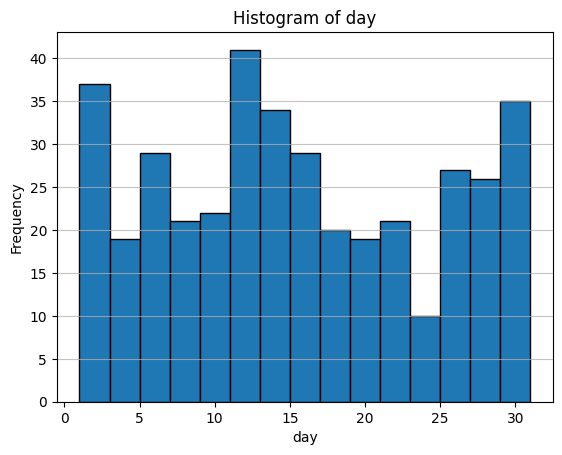

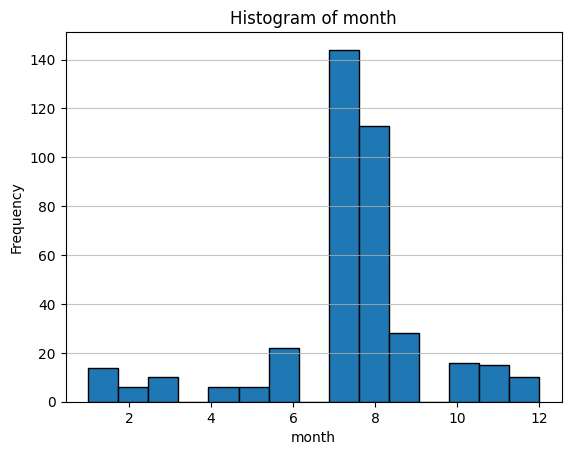

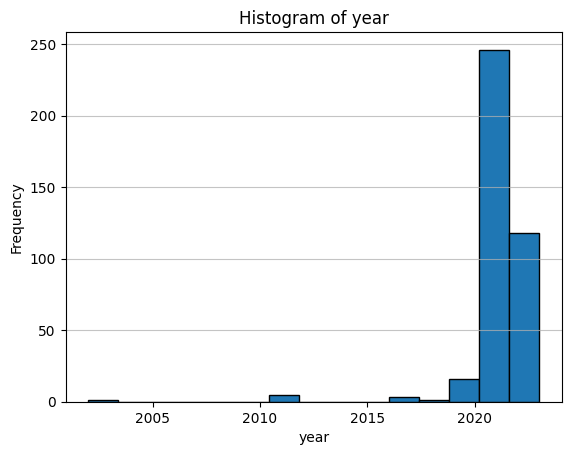

In [538]:
numeric_columns = ['day', 'month', 'year']

# create histograms for 'day', 'month', 'year' columns
for column in numeric_columns:
    plt.figure()
    plt.hist(df[column], bins=15, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


From the Histogram of day, it becomes obvious that most disasters occur in the middle of the month. However, I consider this distribution to be relatively insignificant, as the information does not vary significantly.

In the monthly distribution graph, I saw a fairly normal distribution, with the highest frequency of disasters occurring in months 7 and 8. There were noticeably fewer disasters in the periods before and after

As for the annual distribution graph, it is evident that the graph is skewed to the left. It is show that there were more disasters in the later years.

Create a bar graph to compare the frequency of disasters in order to visualize which disasters occur most frequently in the world.

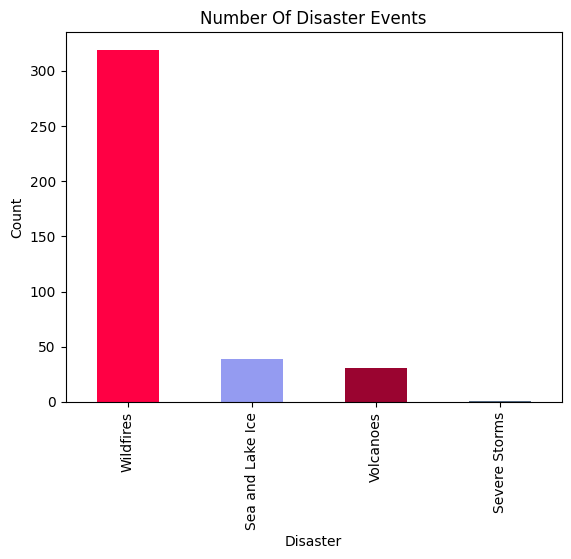

In [539]:
fig, ax = plt.subplots()

df['categories_title'].value_counts().plot.bar(color=['#ff0044', '#949bf1', '#9a0430', '#566c86'], ax=ax)

ax.set_title('Number Of Disaster Events')
ax.set_xlabel('Disaster')
ax.set_ylabel('Count')

plt.show()

From the graph, it can be seen that wildfires disasters occur more frequently in the world than the other three types of disasters combined.

Use heatmaps and bar graphs to determine the months in which each disaster occurs most frequently and find relationship between time (month) and type of disaster.

In [540]:
# In which month does each type of disaster occur most frequently? For example, are severe storms more happen in certain months?
pd.crosstab(df.categories_title,df.month,margins=True).style.background_gradient(cmap='YlOrRd')

month,1,2,3,4,5,6,7,8,9,10,11,12,All
categories_title,,,,,,,,,,,,,
Sea and Lake Ice,3,3,8,0,2,7,0,7,4,2,1,2,39
Severe Storms,0,0,0,0,0,0,0,0,0,0,0,1,1
Volcanoes,4,1,2,0,0,5,4,1,0,2,7,5,31
Wildfires,7,2,0,6,4,10,140,105,24,12,7,2,319
All,14,6,10,6,6,22,144,113,28,16,15,10,390


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


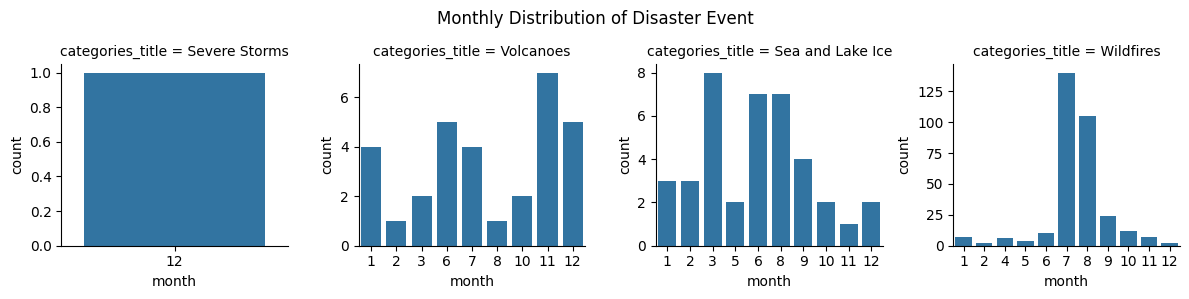

In [541]:
# It is related to seasonal patterns, such as wildfires seasons or severe storms seasons
cat_month_graph = sns.FacetGrid(df, col='categories_title', sharex=False, sharey=False)
cat_month_graph.map(sns.countplot, 'month')

cat_month_graph.fig.subplots_adjust(top=0.8)

cat_month_graph.fig.suptitle('Monthly Distribution of Disaster Event')

plt.show()


From the analysis of both graphs, it was found that the type of disaster and the month have a clear relation, especially in wildfires, which occur most frequently in the middle of the year. The sea and lake ice disasters occur most frequently in months 3, 6, and 8, while severe storms happen only in month 12. Lastly, volcanoes typically occur towards the end of the year (month 11 - month 1).

Therefore, I can assume that each disaster has its own season of occurrence. Disasters can occur outside of their normal range but are not common.

I will create a bar graph to observe the frequency of disasters each year and analyze the trend of disasters.

In [542]:
# Trend of disaster events. 
# Since nowadays, the global warming has had a huge effect, I would like to know if there is a relationship between the year and the number of disaster events.

df['year'].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2016, 2011, 2002], dtype=int32)

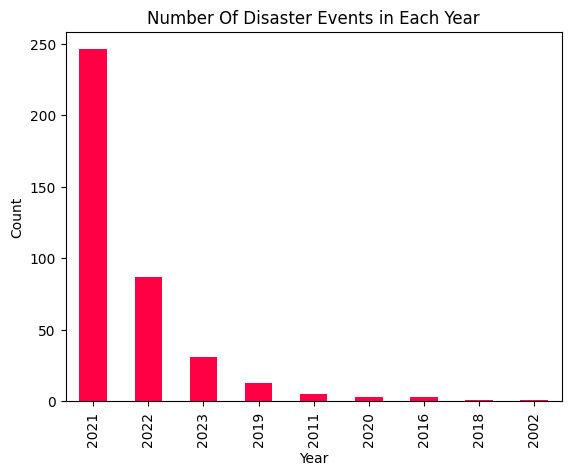

In [543]:
fig, ax = plt.subplots()

df['year'].value_counts().plot.bar(color=['#ff0044'], ax=ax)

ax.set_title('Number Of Disaster Events in Each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Count')

plt.show()

After reviewing the graph, it is evident that 2021 had the highest number of disasters, whereas in 2022, the number of disasters decreased by more than half. However, the number of disasters in consecutive years does not appear to show any significant patterns. Nevertheless, when I consider the decade period from 2013 to 2023, it is clear that this period has a notably higher number of disasters compared to the period prior to 2013.

The increase in disasters over the past decade may be related to global warming, which leads to greater climate instability, hotter summers resulting in more wildfires, and even the melting of ice during winter, despite the winter should cold.

I wanted to determine which continents faced specific types of disasters and identify the most frequent disasters on each continent by analyzing the heat map and ploting bar graphs showing disaster occurrences.

In [544]:
# What disasters occur most often on each continent?
df.groupby(['location','categories_title'])['categories_title'].count()

location       categories_title
Africa         Severe Storms         1
               Wildfires             7
Antarctica     Sea and Lake Ice     39
Asia           Volcanoes            16
Australia      Volcanoes             2
Europe         Volcanoes             3
               Wildfires            45
North America  Volcanoes             4
               Wildfires           266
South America  Volcanoes             6
               Wildfires             1
Name: categories_title, dtype: int64

In [545]:
pd.crosstab(df.location,df.categories_title,margins=True).style.background_gradient(cmap='YlOrRd')

categories_title,Sea and Lake Ice,Severe Storms,Volcanoes,Wildfires,All
location,,,,,
Africa,0,1,0,7,8
Antarctica,39,0,0,0,39
Asia,0,0,16,0,16
Australia,0,0,2,0,2
Europe,0,0,3,45,48
North America,0,0,4,266,270
South America,0,0,6,1,7
All,39,1,31,319,390


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


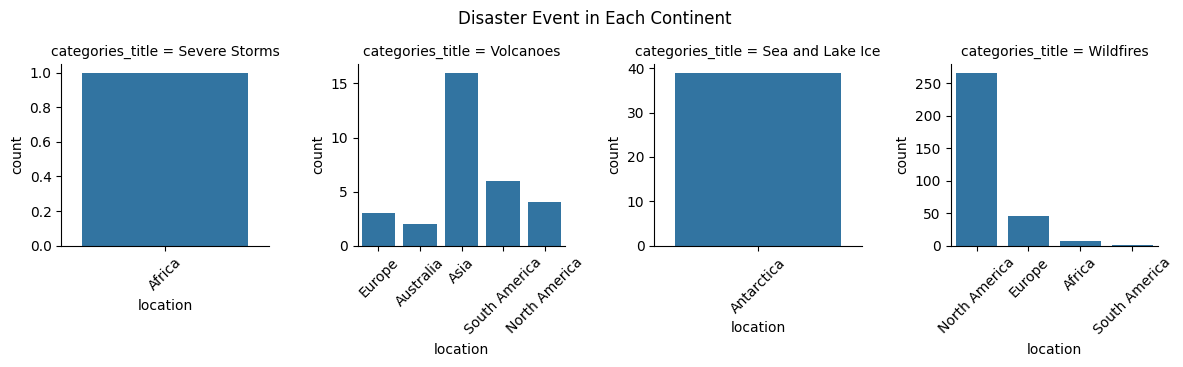

In [546]:
continent_graph = sns.FacetGrid(df, col='categories_title', sharex=False, sharey=False)
continent_graph.map(sns.countplot, 'location')

continent_graph.fig.subplots_adjust(top=0.8)

continent_graph.fig.suptitle('Disaster Event in Each Continent')

for ax in continent_graph.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45) 

plt.show()


From both graphs, it is evident that the majority of volcanoes occur in Asia. Antarctica has the highest frequency of sea and lake ice-related disasters, while wildfires are most common in the United States. Severe storms occurs only in Africa for 1 times.

Based on the data from the graphs, it can be assumed that continents and types of disasters are related. Antarctica with extreme cold, there are only ice and sea, so it is not strange that they faced a higher incidence of sea and lake ice-related disasters than others. Conversely, Asia, South America, and North America have a higher prevalence of volcanoes due to their geographical characteristics, making volcano-related disasters relatively common. When analysing the wildfires, it raises me a question, as North America has the highest number of wildfire incidents. However, considering reports of large wildfires in Australia over the past 5-10 years, there may be some wonder in how NASA collected the data.

In [547]:
# Does the size of the continent affect disasters? Because some continents have larger areas, the chances of disasters are greater?

I will create a scatter plot with the x-axis showing the continent's area and the y-axis representing the frequency of disasters. This will help me determine the relationship between the continent's size and the occurrence of disasters.

In [548]:
# Add more data from https://www.geeksforgeeks.org/7-continents-of-the-world/
location_data = {
    "location": ["Asia", "Africa", "Europe", "North America", "South America", "Australia", "Antarctica"],
    "area_km_sq": [31033131, 29648481, 22134900, 21330000, 17461112, 8486460, 13720000],
}

location_df = pd.DataFrame(location_data)
location_df

,location,area_km_sq
0,Asia,31033131
1,Africa,29648481
2,Europe,22134900
3,North America,21330000
4,South America,17461112
5,Australia,8486460
6,Antarctica,13720000


In [549]:
# select the relevant columns from the old dataframe
df_selected_for_q_3 = df.groupby(['location']).size().reset_index(name='count')

df_selected_for_q_3



,location,count
0,Africa,8
1,Antarctica,39
2,Asia,16
3,Australia,2
4,Europe,48
5,North America,270
6,South America,7


In [550]:
# merge two above dataframe by using left join (based on left table)
df_q_3 = pd.merge(location_df, df_selected_for_q_3, on='location', how='left')
df_q_3

,location,area_km_sq,count
0,Asia,31033131,16
1,Africa,29648481,8
2,Europe,22134900,48
3,North America,21330000,270
4,South America,17461112,7
5,Australia,8486460,2
6,Antarctica,13720000,39


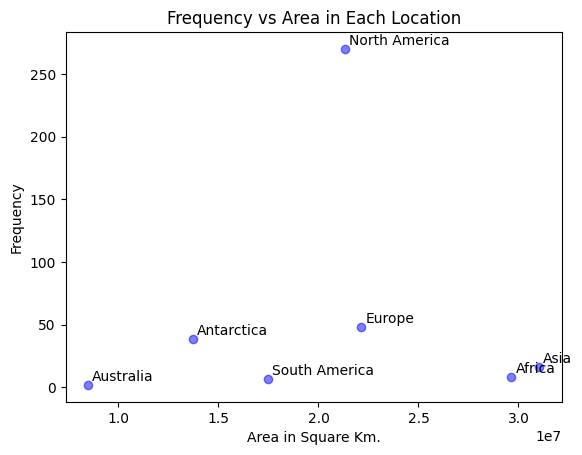

In [551]:
# plot a scatter to show the relation between area size and the occurrence of disasters
plt.figure()
plt.scatter(df_q_3['area_km_sq'], df_q_3['count'], color='blue', alpha=0.5)  

plt.xlabel('Area in Square Km.')
plt.ylabel('Frequency')
plt.title('Frequency vs Area in Each Location')

for index, data in df_q_3.iterrows():
    plt.annotate(data['location'], (data['area_km_sq'], data['count']), textcoords="offset points", xytext=(3,3))

plt.show()

The graph indicates that the size of the continent does not affect the frequency of disasters. While Asia has the largest area, North America has more disasters.

## Step 4: Ask questions about your data 

I have 3 main questions:

1. Do time periods and regions affect the occurrence of disasters?
2. Is global climate change causing more disasters?
3. Is it possible to predict future disasters?

Sub-questions will be shown in each questions.

For the first two questions, I will use graphs and tabular to provide insights into answering these questions before writing my analysis. If there are similar graphs, I will analyze them after the last graph.

For the third question, I will create an two equation (linear regression and polynomial (degree 2)) by using scikit-learn to predict future disasters and calculate the error value. I will primarily focus on the R-Square value because I familiar with this error as I used to use it in the past.

### First Question
- Do time periods and regions affect the occurrence of disasters?
    - Which types of disasters occur more frequently in specific periods compared to others?
    - Do some continents face specific types of disasters more often than others?

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


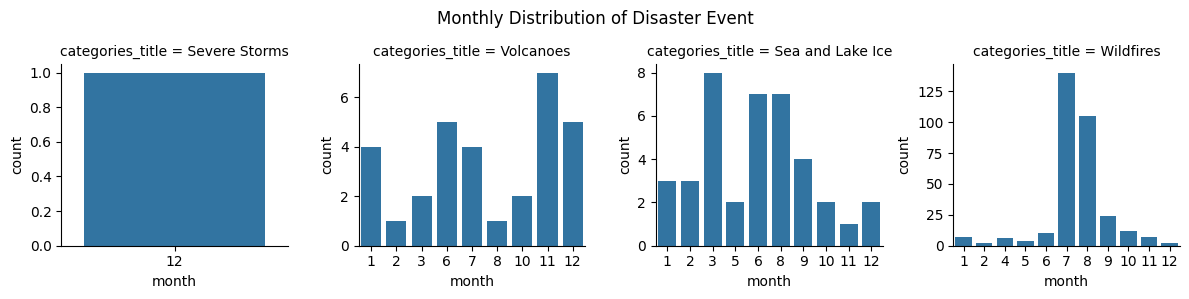

In [552]:
# Which types of disasters occur more frequently in specific periods compared to others?

# check overall Monthly Distribution of Disaster Event
cat_month_graph = sns.FacetGrid(df, col='categories_title', sharex=False, sharey=False)
cat_month_graph.map(sns.countplot, 'month')

cat_month_graph.fig.subplots_adjust(top=0.8)

cat_month_graph.fig.suptitle('Monthly Distribution of Disaster Event')

plt.show()

From the graph, it can be seen that each type of disaster has specific moth in which it occurs frequently, especially wildfires. I will explain in detail later after analyzing another related graph.

In [553]:
df[df['categories_title'] == 'Wildfires']['location'].unique()

array(['North America', 'Europe', 'Africa', 'South America'], dtype=object)

In [554]:
# check the number of wildfires

locations_interest = ['North America', 'Europe', 'Africa', 'South America']

filter_locations_df = df[(df['location'].isin(locations_interest)) & (df['month'].isin([7, 8])) & (df['categories_title'].isin(['Wildfires']))]
filter_locations_df = filter_locations_df.groupby(['location', 'categories_title', 'month'])['categories_title'].count()
filter_locations_df = filter_locations_df.reset_index(name='count')
filter_locations_df

,location,categories_title,month,count
0,Africa,Wildfires,7,2
1,Africa,Wildfires,8,5
2,Europe,Wildfires,7,8
3,Europe,Wildfires,8,27
4,North America,Wildfires,7,129
5,North America,Wildfires,8,73
6,South America,Wildfires,7,1


From the table, it can be seen that North America and Europe have the most wildfires occurrences and they occur most frequently in months 7 and 8.

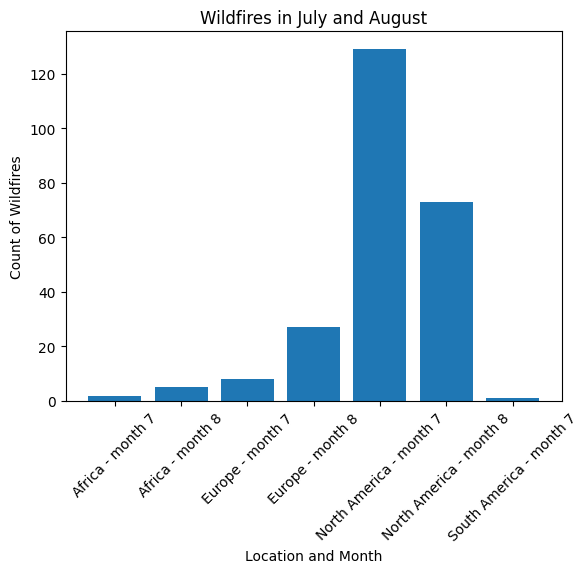

In [555]:
# check for wildfires in July and August, as it had the highest occurrence
plt.figure()
plt.bar(filter_locations_df['location'] + ' - month ' + filter_locations_df['month'].astype(str), filter_locations_df['count'])
plt.xlabel('Location and Month')
plt.ylabel('Count of Wildfires')
plt.title('Wildfires in July and August')
plt.xticks(rotation=45)
plt.show()

From the graph, it is clear that North America faces the highest frequentcy of wildfires in month 7, nearly more than half as many as in month 8. When comparing all the wildfires that have occurred in North America, it is more than the total of all other continents combined.

In [556]:
# check which country Sea and Lake Ice occur in
df[df['categories_title'] == 'Sea and Lake Ice']['location'].unique()

array(['Antarctica'], dtype=object)

In [557]:
# count the number of Sea and Lake Ice occurrences in each month
filter_locations_df_2 = df[(df['location'].isin(['Antarctica'])) & (df['month'].isin([3, 6, 8])) & (df['categories_title'].isin(['Sea and Lake Ice']))]
filter_locations_df_2 = filter_locations_df_2.groupby(['location', 'categories_title', 'month'])['categories_title'].count()
filter_locations_df_2 = filter_locations_df_2.reset_index(name='count')
filter_locations_df_2

,location,categories_title,month,count
0,Antarctica,Sea and Lake Ice,3,8
1,Antarctica,Sea and Lake Ice,6,7
2,Antarctica,Sea and Lake Ice,8,7


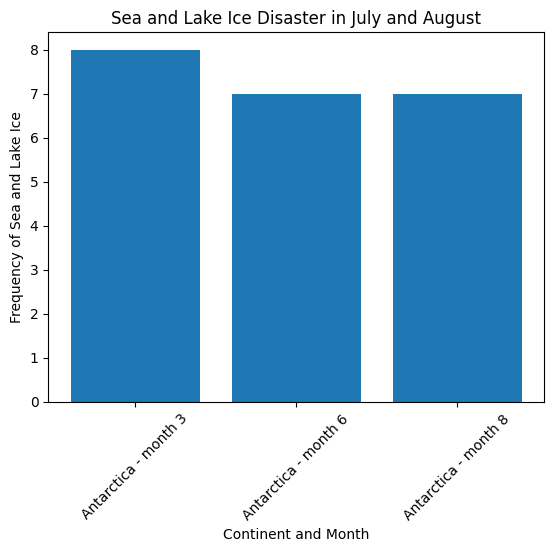

In [558]:
# plot graph Sea and Lake Ice in each month
plt.figure()
plt.bar(filter_locations_df_2['location'] + ' - month ' + filter_locations_df_2['month'].astype(str), filter_locations_df_2['count'])
plt.xlabel('Continent and Month')
plt.ylabel('Frequency of Sea and Lake Ice')
plt.title('Sea and Lake Ice Disaster in July and August')
plt.xticks(rotation=45)
plt.show()

It can be seen that disasters related to ice and sea occur only in Antarctica.

Antarctica's summer is from October to February

From all above graphs, it is evident that Severe Storms occurred only in month 12. However, this data is inconclusive due to the fact that only one Severe Storm has been recorded, and it remains unclear how NASA measured the intensity of these Severe Storms. It is possible that various types of storms occurred, but they might not have been considered severe enough for including in the data collection as Severe Storms. Alternatively, it could be that this dataset still does not collect all the events that actually occurred.

For Sea and Lake, I observe a high number of occurrences in the 3rd, 6th, and 8th months. This is surprising because Sea and Lake disasters occur in Antarctica, where the cold season typically spans from March to November. Could this phenomenon be attributed to global warming? Why does ice melt even during the winter months?

Wildfires are most frequent in the 7th and 8th months, and the data indicates that the majority of these wildfires occur in North America. The data analysis shows that these months (7th and 8th) correspond to the hot summer months in North America. It is possible that extremely hot summers resulting from global warming are causing trees to be unable to adapt. When trees are unable to adapt, it can lead to wildfires.

For disasters like Volcanoes, there is not a distinct pattern in the distribution of occurrences across months. However, the graph shows that the highest number of volcanic disasters is recorded in month 11.

In conclusion, each type of disaster is more likely to occur in a particular month than in other months (They have their own season).

In [559]:
# Do some continents face specific types of disasters more often than others?
# find the number of occurrences for each event and continent
specific_disasters = df.groupby(['location', 'categories_title']).size().reset_index(name = 'count')
specific_disasters

,location,categories_title,count
0,Africa,Severe Storms,1
1,Africa,Wildfires,7
2,Antarctica,Sea and Lake Ice,39
3,Asia,Volcanoes,16
4,Australia,Volcanoes,2
5,Europe,Volcanoes,3
6,Europe,Wildfires,45
7,North America,Volcanoes,4
8,North America,Wildfires,266
9,South America,Volcanoes,6


As you can see from the table, wildfires were the most common disaster, occurring 266 times. I will plot the graph to clearly show how much more frequent they are compared to  any other type of disaster.

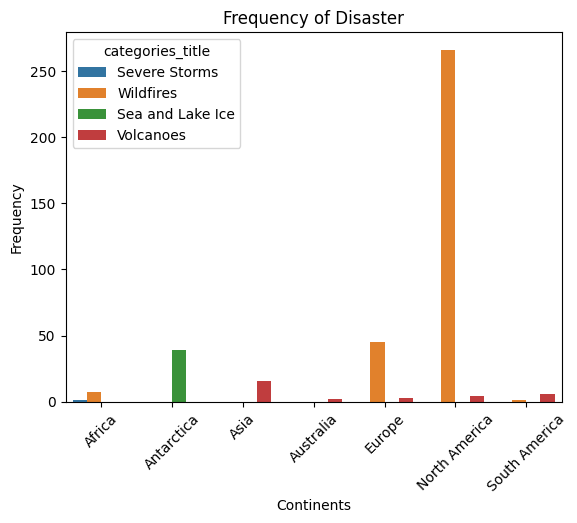

In [560]:
# plot it into bar graph
plt.figure()
sns.barplot(x='location', y='count', hue='categories_title', data= specific_disasters)
plt.title('Frequency of Disaster')
plt.xlabel('Continents')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


From the graph, it can be seen that wildfires occur much more frquently compared to other types of disaster. The bars representing other types of disasters look very small.

In [561]:
# create pivot table before plotting heatmap
pivot_table_specific_disasters = specific_disasters.pivot_table(index='categories_title', columns='location', values='count', fill_value=0)
pivot_table_specific_disasters

location,Africa,Antarctica,Asia,Australia,Europe,North America,South America
categories_title,,,,,,,
Sea and Lake Ice,0.0,39.0,0.0,0.0,0.0,0.0,0.0
Severe Storms,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Volcanoes,0.0,0.0,16.0,2.0,3.0,4.0,6.0
Wildfires,7.0,0.0,0.0,0.0,45.0,266.0,1.0


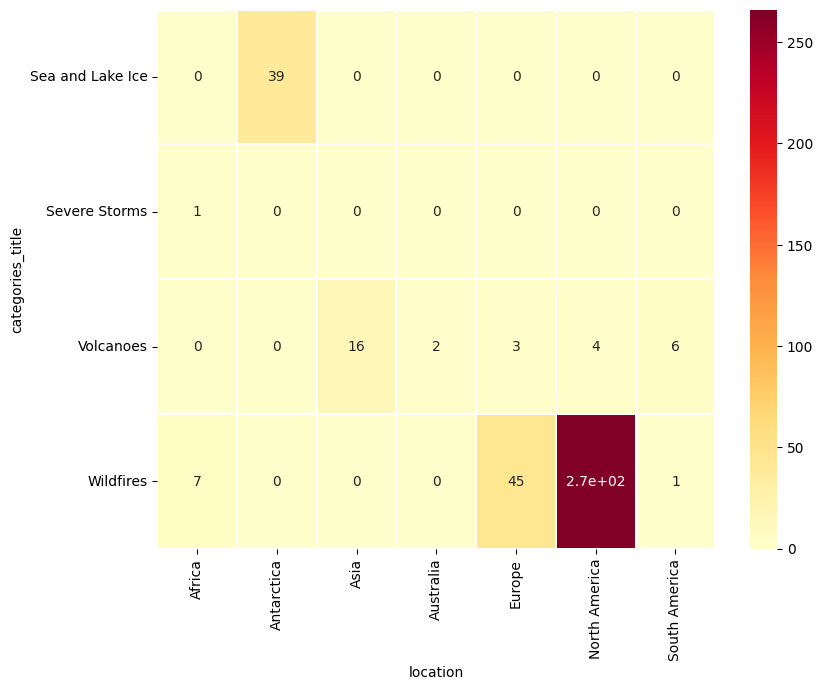

In [562]:
# plot heatmap of disasters and location
sns.heatmap(pivot_table_specific_disasters,annot=True,cmap='YlOrRd',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(9,7)
plt.show()

Looking at the heat map, it is still clear that wildfire disasters are more common in North America, where you can see the color. It is very red.

Moreover, sea and ice-related disasters occur only in Antarctica, as indicate by the dark yellow color.

After analyzing the graph, it becomes evident that wildfire disasters occurred 266 times in North America. Volcanoes were most frequent in Asia, with 16 occurrences, more than the sum total of Australia, Europe, North America and South America (15 times). Severe Storms occurred once in Africa. Disasters related to sea and lake ice were found 39 times in Antarctica but were not happened on other continents.

It is clear that the occurrence of disasters is influenced by the climate and geographical conditions of each continent. In colder countries like Antarctica, it is not surprising that most disasters are related to sea and lake ice. However, in regions like America and Europe, the high frequency of wildfires may be attributed to the climate, where extreme temperature variations between cold winters and hot summers may challenges for trees to adapt.

### Second Question
- Is global climate change causing more disasters?
    - Are disasters occurring more frequently than in the past?
    - Some people say that the world has changed significantly in the past 10 years, like hot weather during the winter season. I want to know whether seasonal disasters have changed in this decade or not?


In [563]:
# Are disasters occurring more frequently than in the past?
conditions = [(df['year'] >= 2014) & (df['year'] <= 2023), (df['year'] >= 2004) & (df['year'] <= 2013), (df['year'] <= 2003)]
values_new_column = ['2014-2023', '2004-2013', 'before 2003']

# create a period column from values_new_column and conditions
df['period'] = np.select(conditions, values_new_column)
df


/var/folders/j7/k1zn5v217flb70ktdfw_fzdc0000gn/T/ipykernel_31979/2092643101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period'] = np.select(conditions, values_new_column)


,title,categories_title,location,day,month,year,period
0,Tropical Cyclone Alvaro,Severe Storms,Africa,31,12,2023,2014-2023
1,"Reykjanes Volcano, Iceland",Volcanoes,Europe,19,12,2023,2014-2023
2,Iceberg A82,Sea and Lake Ice,Antarctica,15,12,2023,2014-2023
3,"Ambae Volcano, Vanuatu",Volcanoes,Australia,11,12,2023,2014-2023
4,"Yasur Volcano, Vanuatu",Volcanoes,Australia,4,12,2023,2014-2023
...,...,...,...,...,...,...,...
394,Iceberg B22A,Sea and Lake Ice,Antarctica,30,8,2011,2004-2013
395,Iceberg C15,Sea and Lake Ice,Antarctica,30,8,2011,2004-2013
396,Iceberg B09B,Sea and Lake Ice,Antarctica,30,8,2011,2004-2013
397,Iceberg D20A,Sea and Lake Ice,Antarctica,30,8,2011,2004-2013


In [564]:
period_disasters = df.groupby(['period']).size().reset_index(name = 'count')
period_disasters

,period,count
0,2004-2013,5
1,2014-2023,384
2,before 2003,1


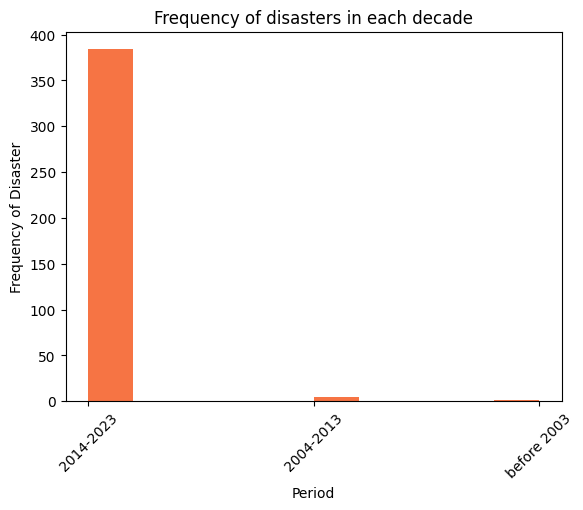

In [565]:
plt.figure()
plt.hist(df['period'], color='#f67444')
plt.xlabel('Period')
plt.ylabel('Frequency of Disaster')
plt.title('Frequency of disasters in each decade')
plt.xticks(rotation=45)
plt.show()

From the graph, it is obvios that global warming has had a significant impact on disasters. In the past 10 years, there have been nearly 400 disasters in the world, which is 64 times more than in the previous 20 years.

Meteorological Seasons -https://www.timeanddate.com/calendar/aboutseasons.html
- spring runs from March 1 to May 31; -> month 3-5
- summer runs from June 1 to August 31; -> month 6-8
- fall (autumn) runs from September 1 to November 30; -> month 9-11 and.
- winter runs from December 1 to February 28 (February 29 in a leap year). -> month 12-2

In [566]:
# Some people say that the world has changed significantly in the past 10 years, like hot weather during the winter season. 
# I want to know whether seasonal disasters have changed in this decade or not?

season_conditions = [(df['month'] == 12) | (df['month'] ==1) | (df['month'] ==2), (df['month'] >= 3) & (df['month'] <= 5), (df['month'] >= 6) & (df['month'] <= 8), (df['month'] >= 9) & (df['month'] <= 11)]
values_column_season = ['winter', 'spring', 'summer', 'autumn']

# create a season column from season_conditions and values_column_season
df['season'] = np.select(season_conditions, values_column_season)
df

,title,categories_title,location,day,month,year,period,season
0,Tropical Cyclone Alvaro,Severe Storms,Africa,31,12,2023,2014-2023,winter
1,"Reykjanes Volcano, Iceland",Volcanoes,Europe,19,12,2023,2014-2023,winter
2,Iceberg A82,Sea and Lake Ice,Antarctica,15,12,2023,2014-2023,winter
3,"Ambae Volcano, Vanuatu",Volcanoes,Australia,11,12,2023,2014-2023,winter
4,"Yasur Volcano, Vanuatu",Volcanoes,Australia,4,12,2023,2014-2023,winter
...,...,...,...,...,...,...,...,...
394,Iceberg B22A,Sea and Lake Ice,Antarctica,30,8,2011,2004-2013,summer
395,Iceberg C15,Sea and Lake Ice,Antarctica,30,8,2011,2004-2013,summer
396,Iceberg B09B,Sea and Lake Ice,Antarctica,30,8,2011,2004-2013,summer
397,Iceberg D20A,Sea and Lake Ice,Antarctica,30,8,2011,2004-2013,summer


In [567]:
# count the number of disasters that occur during each year and season.
test = df.groupby(['season', 'period', 'categories_title'])
test = test.size().reset_index(name='count')
test

,season,period,categories_title,count
0,autumn,2014-2023,Sea and Lake Ice,7
1,autumn,2014-2023,Volcanoes,9
2,autumn,2014-2023,Wildfires,43
3,spring,2014-2023,Sea and Lake Ice,10
4,spring,2014-2023,Volcanoes,2
5,spring,2014-2023,Wildfires,10
6,summer,2004-2013,Sea and Lake Ice,5
7,summer,2014-2023,Sea and Lake Ice,9
8,summer,2014-2023,Volcanoes,10
9,summer,2014-2023,Wildfires,255


In [568]:
# I will show the table above with color to make it clearly.
pd.crosstab([df.season,df.period],df.categories_title,margins=True).style.background_gradient(cmap='summer_r')

From the graph, it shows that the occurence disaster period has not shifted significantly. They continue to occur at similar times, seemingly unaffected by weather fluctuations. For example, volcanic events in the summer still takes place during the summer as it did before. However, this data cannot be analyzed accurately because there are not many disasters that occurred before 2014 collected in this dataset

Perhaps the world has not undergone significant changes in the past 10 years, but it undergoes continuous transformation every day, but in the last decade, humans are increasingly recognizing the impact of global warming. So, they think that the world has changed more during this period.

### Third Question
- Is it possible to predict disasters for the future? 
    - Can we predict what the frequency of disaster in the next 30 years?
    - Which one is more effective, linear regression or polynomial regression, in predicting the number of disasters based on data?

In [569]:
# Can we predict what the frequency of disaster in the next 30 years?

# groupby year and count the number of occurrences
test_2 = df.groupby(['year'])
test_2 = test_2.size().reset_index(name='count')

test_2


,year,count
0,2002,1
1,2011,5
2,2016,3
3,2018,1
4,2019,13
5,2020,3
6,2021,246
7,2022,87
8,2023,31


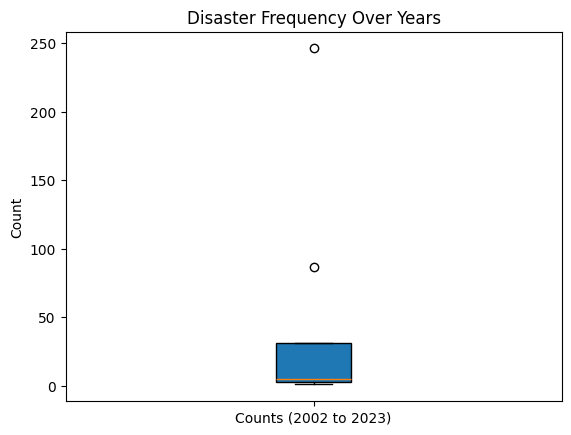

In [570]:
# use box plot to identify outlier
plt.figure()  
plt.boxplot(test_2['count'], patch_artist=True) 

plt.title('Disaster Frequency Over Years')
plt.ylabel('Count')
plt.xticks([1], [f'Counts ({test_2["year"].min()} to {test_2["year"].max()})'])

plt.show()

At first, I plotted the box plot to identify outliers because I want to remove them. However, I was surprised that removing these outliers caused the R-squared value to far further from 1. This outcome led me to do nothing with outliers.

In [571]:
X = test_2[['year']]
y = test_2['count']

Linear Regression

In [572]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# create model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_test_pred = linear_model.predict(X_test)
y_train_pred = linear_model.predict(X_train)

In [573]:
# finding the constant in equation
# y= ax+b
# a is the slope (coef), b is the intercept
intercept = linear_model.intercept_
coef = linear_model.coef_
print ("a=", coef," b= ", intercept)

a= [4.25220848]  b=  -8530.810070671378


In [574]:
# find the error (MSE)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_pred))

Mean squared error: 943.51


In [575]:
# find the error (R-square)
print("R-square of test set is:", r2_score(y_test, y_test_pred))

R-square of test set is: 0.4651284768876869


In [576]:
# predict the number of disaster in 2053
y_predict = coef * 2053 + intercept
print ("Number of disaster in 2053 are", y_predict)

Number of disaster in 2053 are [198.97393993]


I got R-square = 0.465 which is quite low and unacceptable.

The model predicts that Number of disaster in 2053 are 199

Polynomial

In [577]:
X = test_2[['year']]
y = test_2['count']

In [578]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# create polynomial model (degree 2)
degree = 2  

poly_features = PolynomialFeatures(degree = degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_train_predicted = poly_model.predict(X_train_poly)
y_test_predicted = poly_model.predict(X_test_poly)

In [579]:
# find the error (MSE)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_predicted))

Mean squared error: 147.60


In [580]:
# find the error (R-square)
print("R-square is:", r2_score(y_test, y_test_predicted))

R-square is: 0.9163281775684488


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


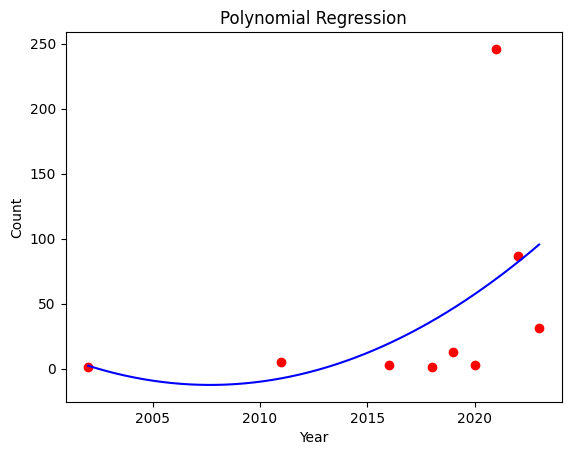

In [581]:
# reshape X_fit
X_fit = np.linspace(X.min(), X.max()).reshape(-1, 1)

# use Reshaped X_fit for Y_fit
Y_fit = poly_model.predict(poly_features.transform(X_fit))

# plot X_fit and Y_fit
plt.scatter(X, y, color='red')
plt.plot(X_fit, Y_fit, color='blue')
plt.title('Polynomial Regression')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

I created the plot to determine if the model fits the data, and from the graph, in my opinion it is acceptable

In [582]:
# predict the number of disaster in 2053
years_poly = poly_features.transform([[2053]])
y_predictions = poly_model.predict(years_poly)
print(f"Number of disaster in 2053 are {y_predictions}")

Number of disaster in 2053 are [931.79176353]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


I got R-square = 0.916 which is acceptable.

The model predicts that Number of disaster in 2053 are 932

I have created two equations to predict the probability of a disaster occurring on Earth's surface over the next 30 years. The first equation is a linear regression model with an R-squared value of 0.465, and its model predicts that 199 disasters will occur in the 2053.

In the polynomial equation (degree 2), I get an R-squared value of 0.916, and its model predicts that 932 disasters will occur in the 2053.

After seeing R-squared value, I have found that polynomial equations are more reliable because of the higher R-squared value (near 1). The higher R-squared value makes the polynomial equation more effective at prediction. So, I can predict that disaster occurring in the next 30 years is estimated to be 932 times.

## Step 5: Summarise and write a conclusion

### Write a summary of what you've learned from the analysis.

I learned that disasters tend to occur more frequently in certain months. For example, wildfiers were more common in months 7 and 8. Although my findings were limited by the small size of the dataset, I am confident that there is a relationship between disasters and seasonality.

The effects of global warming are particularly evident in the data from Antarctica. Surprisingly, there is ice-related disasters during the colder months, which may indicate the effects of global warming.

Additionally, I found that geography and climate have a significant influence on the occurrence of disasters. For example, in Antarctica, most disasters are related to ice due to the geographic of icebergs and ice lake. Similarly, wildfiers are frequent in North America during the summer, possibly because the trees are not familiar to extremely hot summers. The extremely hot summers led to increased incidences of wildfires during this period.

Moreover, my analysis of disasters over time show that the frequency and timing of disasters have remained consistent, regardless of changes in the world. For example, volcanic eruptions most commonly occur in the summer.

In addition, the impact of global warming is undeny. There has been a noticeable increase in the number of disasters over the past decade compared to previous periods.

Finally, in my predictive modeling, I discovered that polynomial equations are more accurate than linear equations for disaster prediction. The higher R-squared values of the polynomial equations (degree 2) enable me to predict disasters over the next 30 years more reliably.




### Share ideas for future work on the same topic using other relevant datasets/sources.

If possible, I want to gather information from more sources to make a more comprehensive analysis. This is because most of the data in this analysis is non-numeric, which limits the statistical analysis. Additionally, I would like to include information about the climate in the dataset. This will allow for a clearer comparison to determine whether the weather has an impact on these events.

Additionally, I saw on the NASA website that there is information about the Mars. I would like to make a comparative analysis of the climates on Mars and Earth. This is because in the past people believe that humans from Earth could relocate to Mars. I am interested in understanding why people think this way.

I realized that the data in the API continued change, so I will keep it in my mind that I should use and test data from CSV file in my analysis. If I have the task like this in the future, I will be more careful with this problem.